## Process `sa-bac` runs from Terra workspace

In [94]:
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
import pickle

from typing import Tuple, Dict

from ruamel_yaml import YAML

from mighty_codes.sa_bac.main import \
    SimulatedAnnealingBinaryAsymmetricChannel

yaml = YAML()
yaml.indent(mapping=2, sequence=4, offset=2)

## Process

In [95]:
sample_sheet_path = '/home/jupyter/mb-ml-data-disk/MightyCodes/sa_bac/sample-03-07-2021.csv'
data_root = '/home/jupyter/mb-ml-data-disk/MightyCodes/sa_bac'

In [96]:
# load sample sheet
sample_pd = pd.read_csv(sample_sheet_path, delimiter='\t')

In [97]:
sample_pd.columns

Index(['entity:sample_id', 'base_yaml_file', 'channel_model',
       'checkpoint_interval_seconds', 'code_length', 'convergence_abs_tol',
       'convergence_countdown', 'eval_split_size', 'experiment_prefix',
       'final_state', 'max_hamming_weight', 'metric_type',
       'mighty_codes_tar_gz', 'min_hamming_weight', 'n_types',
       'quality_factor', 'source_nonuniformity'],
      dtype='object')

In [98]:
def instantiate_sa_bac_from_checkpoint(checkpoint_path: str) -> SimulatedAnnealingBinaryAsymmetricChannel:
    
    # load YAML file
    with open(os.path.join(checkpoint_path, "params.yaml")) as params_yaml_file:
        params = yaml.load(params_yaml_file)
        
    # add missing keywords (to allow loading older versions ...)
    if 'reheating_resampling_beta_ratio' not in params:
        params['reheating_resampling_beta_ratio'] = 5.0
    
    sa_bac = SimulatedAnnealingBinaryAsymmetricChannel(
        params=params,
        logger=print)
    
    sa_bac.ptpsa.load_state_dict(
        torch.load(
            os.path.join(checkpoint_path, 'latest_state.pkl')))
    
    return params, sa_bac


def load_state_dict_from_checkpoint(checkpoint_path: str) -> Tuple[Dict, Dict]:
    # load YAML file
    with open(os.path.join(checkpoint_path, "params.yaml")) as params_yaml_file:
        params = yaml.load(params_yaml_file)

    # load state dict
    state_dict = torch.load(os.path.join(checkpoint_path, 'latest_state.pkl'))
    
    return params, state_dict

In [ ]:
sa_bac_df = pd.DataFrame(
    {'entity:sample_id': pd.Series([], dtype='str'),
     'channel_model': pd.Series([], dtype='str'),
     'code_length': pd.Series([], dtype='int'),
     'n_types': pd.Series([], dtype='int'),
     'min_hamming_weight': pd.Series([], dtype='int'),
     'max_hamming_weight': pd.Series([], dtype='int'),
     'metric_type': pd.Series([], dtype='str'),
     'source_nonuniformity': pd.Series([], dtype='float'),
     'lowest_energy_sa': pd.Series([], dtype='float'),
     'rand_state_energy_loc': pd.Series([], dtype='float'),
     'rand_state_energy_scale': pd.Series([], dtype='float'),
     'i_iter': pd.Series([], dtype='int'),
     'i_cycle': pd.Series([], dtype='int'),
    })

sa_bac_pi_t_dict = dict()
sa_bac_best_metrics_dict = dict()
sa_bac_best_codebook_tl_dict = dict()

n_samples = len(sample_pd['entity:sample_id'])

for i_sample in range(n_samples):
    row = sample_pd.iloc[i_sample]
    print(f"Loading {i_sample + 1} / {n_samples} ...")
    
    # load checkpoint
    params, sa_bac = instantiate_sa_bac_from_checkpoint(
        os.path.join(data_root, row['entity:sample_id']))
    
    # populate dataframe
    sa_bac_df = sa_bac_df.append(
        {'entity:sample_id': row['entity:sample_id'],
         'channel_model': row['channel_model'],
         'code_length': row['code_length'],
         'n_types': row['n_types'],
         'min_hamming_weight': row['min_hamming_weight'],
         'max_hamming_weight': row['max_hamming_weight'],
         'metric_type': row['metric_type'],
         'source_nonuniformity': row['source_nonuniformity'],
         'lowest_energy_sa': sa_bac.ptpsa.top_energy,
         'rand_state_energy_loc': params['rand_state_energy_loc'],
         'rand_state_energy_scale': params['rand_state_energy_scale'],
         'i_iter': sa_bac.ptpsa.i_iter,
         'i_cycle': sa_bac.ptpsa.i_cycle},
        ignore_index=True)

    # prior
    pi_t_np = sa_bac.ptpsa.batched_state_energy_calculator.pi_t.cpu().numpy()

    # best codebook
    codebook_tl_np = sa_bac.ptpsa.batched_state_energy_calculator.state_bx_to_codebook_btl(
        sa_bac.ptpsa.top_state_kx[0, :][None, :])[0].cpu().numpy().astype(np.int)
    
    # metrics for the best codebook
    metrics_dict = sa_bac.ptpsa.batched_state_energy_calculator.calculate_state_metrics_dict(
        sa_bac.ptpsa.top_state_kx[0, :][None, :])
    metrics_dict_np = {
        'tpr_t': metrics_dict['tpr_bt'][0, :].cpu().numpy(),
        'fdr_t': metrics_dict['fdr_bt'][0, :].cpu().numpy(),
        'fpr_t': metrics_dict['fpr_bt'][0, :].cpu().numpy(),
        'f_1_t': metrics_dict['f_1_bt'][0, :].cpu().numpy()}
    
    sample_id = row['entity:sample_id']
    sa_bac_pi_t_dict[sample_id] = pi_t_np
    sa_bac_best_codebook_tl_dict[sample_id] = codebook_tl_np
    sa_bac_best_metrics_dict[sample_id] = metrics_dict_np

## Save

In [97]:
sa_bac_df.to_csv('./sa_bac_df.tsv', sep='\t', index=False)

with open('./sa_bac_pi_t_dict.pkl', 'wb') as f:
    pickle.dump(sa_bac_pi_t_dict, f)
with open('./sa_bac_best_metrics_dict.pkl', 'wb') as f:
    pickle.dump(sa_bac_best_metrics_dict, f)
with open('./sa_bac_best_codebook_tl_dict.pkl', 'wb') as f:
    pickle.dump(sa_bac_best_codebook_tl_dict, f)

## Load

In [99]:
root_path = '/home/jupyter/mb-ml-dev-disk/MightyCodes/notebooks/terra_analysis'
sa_bac_df = pd.read_csv(os.path.join(root_path, 'sa_bac_w_var_df.tsv'), delimiter='\t')
with open(os.path.join(root_path, 'sa_bac_pi_t_dict.pkl'), 'rb') as f:
    sa_bac_pi_t_dict = pickle.Unpickler(f).load()
with open(os.path.join(root_path, 'sa_bac_best_metrics_dict.pkl'), 'rb') as f:
    sa_bac_best_metrics_dict = pickle.Unpickler(f).load()
with open(os.path.join(root_path, 'sa_bac_best_codebook_tl_dict.pkl'), 'rb') as f:
    sa_bac_best_codebook_tl_dict = pickle.Unpickler(f).load()
    
# add "sa_bac__first_wave__" to the first 90 samples
sa_bac_df['entity:sample_id'][:90] = np.asarray(
    list("sa_bac__first_wave__" + sample_id for sample_id in sa_bac_df['entity:sample_id'][:90].values))[:]

sa_bac_best_codebook_tl_dict__fixed = dict()
for k, v in sa_bac_best_codebook_tl_dict.items():
    if k.find('sa_bac__') != 0:
        new_key = "sa_bac__first_wave__" + k
        sa_bac_best_codebook_tl_dict__fixed[new_key] = v
    else:
        sa_bac_best_codebook_tl_dict__fixed[k] = v
sa_bac_best_codebook_tl_dict = sa_bac_best_codebook_tl_dict__fixed

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Visualize

In [100]:
sa_bac_df

,entity:sample_id,channel_model,code_length,n_types,min_hamming_weight,max_hamming_weight,metric_type,source_nonuniformity,lowest_energy_sa,rand_state_energy_loc,rand_state_energy_scale,i_iter,i_cycle,lowest_energy_var
0,sa_bac__first_wave__channel_bac_merfish__10__1...,channel_bac_merfish,10,128,1,9,fdr,1000.0,0.386121,0.565272,0.008058,244238,25,0.419856
1,sa_bac__first_wave__channel_bac_merfish__10__1...,channel_bac_merfish,10,128,1,9,fdr,100.0,0.356892,0.493721,0.007409,243857,25,0.391821
2,sa_bac__first_wave__channel_bac_merfish__10__1...,channel_bac_merfish,10,128,1,9,fdr,10.0,0.336073,0.433206,0.005948,244092,25,0.375689
3,sa_bac__first_wave__channel_bac_merfish__10__1...,channel_bac_merfish,10,16,1,9,fdr,1000.0,0.080560,0.232028,0.032121,157117,12,0.115169
4,sa_bac__first_wave__channel_bac_merfish__10__1...,channel_bac_merfish,10,16,1,9,fdr,100.0,0.065245,0.173081,0.024789,179819,16,0.082878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,sa_bac__second_wave__channel_bac_merfish__9__2...,channel_bac_merfish,9,32,2,7,fdr,100.0,0.179623,0.325108,0.018612,57464,12,0.208665
176,sa_bac__second_wave__channel_bac_merfish__9__2...,channel_bac_merfish,9,32,2,7,fdr,10.0,0.147834,0.270172,0.014047,264962,53,0.186803
177,sa_bac__second_wave__channel_bac_merfish__9__2...,channel_bac_merfish,9,64,2,7,fdr,1000.0,0.334317,0.520376,0.012751,268364,53,0.370947
178,sa_bac__second_wave__channel_bac_merfish__9__2...,channel_bac_merfish,9,64,2,7,fdr,100.0,0.300316,0.445182,0.011710,261389,53,0.337976


In [107]:
def select_rows(
        sa_bac_df: pd.DataFrame,
        sample_id_prefix: str,
        min_hamming_weight: int,
        source_nonuniformity: float) -> pd.DataFrame:
    
    n_samples = len(sa_bac_df)
    
    selected_indices = []
    for i_sample in range(n_samples):
        row = sa_bac_df.iloc[i_sample]
        if row['entity:sample_id'].find(sample_id_prefix) != 0:
            continue
        if row['min_hamming_weight'] != min_hamming_weight:
            continue
        if abs(row['source_nonuniformity'] - source_nonuniformity) > 1e-3:
            continue
        selected_indices.append(i_sample)
        
    return sa_bac_df.iloc[selected_indices]


def plot_codebook_specs(ax):
    """Warning: this method uses workspace variables extensively"""

    subset_sa_bac_df = select_rows(
        sa_bac_df=sa_bac_df,
        sample_id_prefix=sample_id_prefix,
        min_hamming_weight=min_hamming_weight,
        source_nonuniformity=source_nonuniformity)

    subset_sa_bac_df = subset_sa_bac_df.sort_values(by=[c_axis])
    code_length_arr = subset_sa_bac_df['code_length'].values
    n_types_arr = subset_sa_bac_df['n_types'].values
    lowest_energy_sa_arr = subset_sa_bac_df['lowest_energy_sa'].values
    rand_state_energy_loc_arr = subset_sa_bac_df['rand_state_energy_loc'].values
    rand_state_energy_scale_arr = subset_sa_bac_df['rand_state_energy_scale'].values

    try:
        lowest_energy_var_arr = subset_sa_bac_df['lowest_energy_var'].values
    except:
        pass

    data_map = {
        'n_types': n_types_arr,
        'code_length': code_length_arr,
        'sa': lowest_energy_sa_arr,
        'var': lowest_energy_var_arr,
        'rand': rand_state_energy_loc_arr,
        'sa_to_rand': lowest_energy_sa_arr / rand_state_energy_loc_arr,
        'var_to_rand': lowest_energy_var_arr / rand_state_energy_loc_arr,
    }

    label_map = {
        'n_types': 'Number of Types (T)',
        'code_length': 'Code Length (L)'
    }

    marker_map = {
        'sa': codebook_sa_marker,
        'var': codebook_var_marker,
        'rand': codebook_rand_marker,
        'sa_to_rand': codebook_sa_marker,
        'var_to_rand': codebook_var_marker
    }
    
    marker_size_map = {
        'sa': codebook_sa_marker_size,
        'var': codebook_var_marker_size,
        'rand': codebook_rand_marker_size,
        'sa_to_rand': codebook_sa_marker_size,
        'var_to_rand': codebook_var_marker_size
    }

    short_label_map = {
        'n_types': 'T',
        'code_length': 'L'
    }

    x_axis_data = data_map[x_axis]
    x_axis_label = label_map[x_axis]
    c_axis_data = data_map[c_axis]
    y_axis_data = data_map[y_axis]
    marker = marker_map[y_axis]
    marker_size = marker_size_map[y_axis]
    
    c_to_rank_map = {c: r for r, c in enumerate(sorted(list(set(c_axis_data))))}
    min_rank = np.min(list(c_to_rank_map.values()))
    max_rank = np.max(list(c_to_rank_map.values()))
    color_function = lambda value: \
        (c_to_rank_map[value] - min_rank) * hi_color / (max_rank - min_rank) + \
        (max_rank - c_to_rank_map[value]) * lo_color / (max_rank - min_rank)

    # plot lines
    for c in c_to_rank_map.keys():

        indices = [idx for idx in range(len(subset_sa_bac_df)) if abs(c_axis_data[idx] - c) < 1e-3]
        x = x_axis_data[indices]
        y = y_axis_data[indices]
        s = np.argsort(x)
        ax.plot(x[s], y[s], '--', color=gray_color, lw=1)

    # plot markers
    label_set = set()
    for idx in range(len(subset_sa_bac_df)):

        x = x_axis_data[idx]
        y = y_axis_data[idx]
        c = c_axis_data[idx]
        color = color_function(c)
        label = f'{short_label_map[c_axis]} = {c}' if c not in label_set else None
        label_set.add(c)

        ax.scatter(
            x, y, color=color,
            marker=marker,
            s=marker_size,
            label=label)
        
    # plot error bars
    if y_axis == 'rand':
        for idx in range(len(subset_sa_bac_df)):

            x = x_axis_data[idx]
            y = y_axis_data[idx]
            yerr = rand_state_energy_scale_arr[idx]
            c = c_axis_data[idx]
            color = color_function(c)

            ax.errorbar(
                x, y, yerr,
                color=color, capsize=2, elinewidth=1,
                marker=None,
                markersize=0)
        
    ax.set_yscale(y_scale)
    ax.set_xscale(x_scale)
    ax.set_ylabel(y_label)
    ax.set_ylim((ax.get_ylim()[0], 1.0))

    ax.set_xticks(sorted(list(set(x_axis_data))))
    ax.set_xticklabels(sorted(list(set(x_axis_data))))
    ax.set_xlabel(x_axis_label)

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)

    ax.legend(loc=legend_loc, fontsize=9, ncol=2)

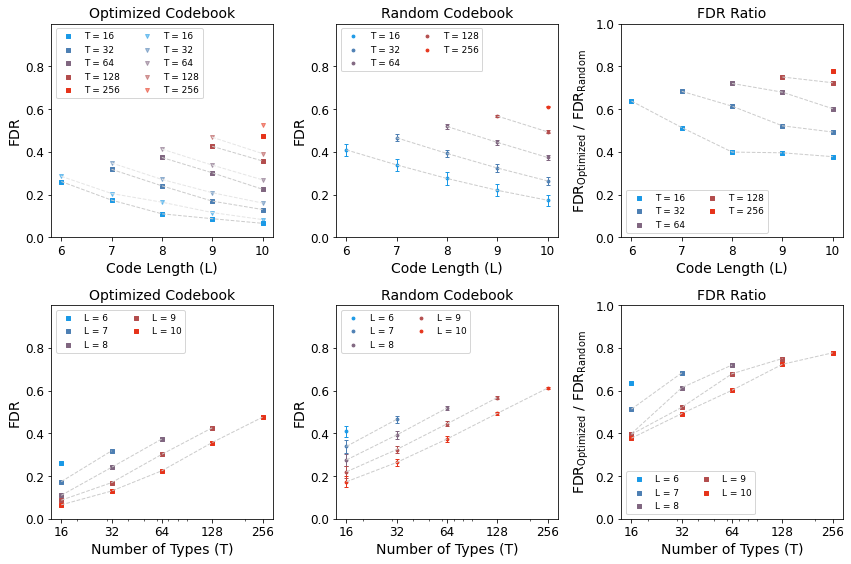

In [110]:
min_hamming_weight = 2
sample_id_prefix = 'sa_bac__first_wave__'
source_nonuniformity = 1000.

gray_color = np.asarray([0.8, 0.8, 0.8])
hi_color = np.asarray([0.9, 0.2, 0.1])
lo_color = np.asarray([0.1, 0.6, 0.9])

codebook_sa_marker = 's'
codebook_sa_marker_size = 16

codebook_rand_marker = 'o'
codebook_rand_marker_size = 8

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

###### x_axis = 'code_length'

c_axis = 'n_types'
x_axis = 'code_length'
y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8]
legend_loc = 'upper left'

y_axis = 'sa'
y_label = 'FDR'
x_scale = 'linear'
y_scale = 'linear'
plot_codebook_specs(axs[0, 0])

y_axis = 'rand'
y_label = 'FDR'
x_scale = 'linear'
y_scale = 'linear'
plot_codebook_specs(axs[0, 1])

y_axis = 'sa_to_rand'
x_scale = 'linear'
y_scale = 'linear'
y_label = r'$\mathrm{FDR}_\mathrm{Optimized}~/~\mathrm{FDR}_\mathrm{Random}$'
y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
legend_loc = 'lower left'
plot_codebook_specs(axs[0, 2])

###### x_axis = 'n_types'

c_axis = 'code_length'
x_axis = 'n_types'
y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8]
legend_loc = 'upper left'

y_axis = 'sa'
y_label = 'FDR'
x_scale = 'log'
y_scale = 'linear'
plot_codebook_specs(axs[1, 0])

y_axis = 'rand'
y_label = 'FDR'
x_scale = 'log'
y_scale = 'linear'
plot_codebook_specs(axs[1, 1])

y_axis = 'sa_to_rand'
x_scale = 'log'
y_scale = 'linear'
y_label = r'$\mathrm{FDR}_\mathrm{Optimized}~/~\mathrm{FDR}_\mathrm{Random}$'
y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
legend_loc = 'lower left'
plot_codebook_specs(axs[1, 2])

axs[0, 0].set_title('Optimized Codebook', fontsize=14)
axs[0, 1].set_title('Random Codebook', fontsize=14)
axs[0, 2].set_title('FDR Ratio', fontsize=14)

axs[1, 0].set_title('Optimized Codebook', fontsize=14)
axs[1, 1].set_title('Random Codebook', fontsize=14)
axs[1, 2].set_title('FDR Ratio', fontsize=14)

fig.tight_layout()
plt.savefig(f'./output/{sample_id_prefix}metrics__min_hw_{min_hamming_weight}__src_nonunif_{int(source_nonuniformity)}.png', dpi=120)

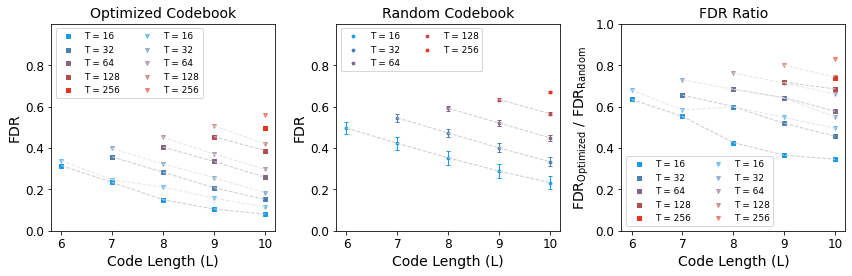

In [120]:
min_hamming_weight = 2
sample_id_prefix = 'sa_bac__first_wave__'
source_nonuniformity = 1000.

gray_color = np.asarray([0.8, 0.8, 0.8])
hi_color = np.asarray([0.9, 0.2, 0.1])
lo_color = np.asarray([0.1, 0.6, 0.9])

codebook_sa_marker = 's'
codebook_sa_marker_size = 16

codebook_var_marker = 'v'
codebook_var_marker_size = 16

codebook_rand_marker = 'o'
codebook_rand_marker_size = 8

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

###### x_axis = 'code_length'

c_axis = 'n_types'
x_axis = 'code_length'
y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8]
legend_loc = 'upper left'

y_axis = 'sa'
y_label = 'FDR'
x_scale = 'linear'
y_scale = 'linear'
plot_codebook_specs(axs[0])

gray_color = np.asarray([0.9, 0.9, 0.9])
hi_color = np.asarray([0.9, 0.2, 0.1, 0.5])
lo_color = np.asarray([0.1, 0.6, 0.9, 0.5])

y_axis = 'var'
y_label = 'FDR'
x_scale = 'linear'
y_scale = 'linear'
plot_codebook_specs(axs[0])

gray_color = np.asarray([0.8, 0.8, 0.8])
hi_color = np.asarray([0.9, 0.2, 0.1])
lo_color = np.asarray([0.1, 0.6, 0.9])

y_axis = 'rand'
y_label = 'FDR'
x_scale = 'linear'
y_scale = 'linear'
plot_codebook_specs(axs[1])

y_axis = 'sa_to_rand'
x_scale = 'linear'
y_scale = 'linear'
y_label = r'$\mathrm{FDR}_\mathrm{Optimized}~/~\mathrm{FDR}_\mathrm{Random}$'
y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
legend_loc = 'lower left'
plot_codebook_specs(axs[2])

gray_color = np.asarray([0.9, 0.9, 0.9])
hi_color = np.asarray([0.9, 0.2, 0.1, 0.5])
lo_color = np.asarray([0.1, 0.6, 0.9, 0.5])

y_axis = 'var_to_rand'
x_scale = 'linear'
y_scale = 'linear'
y_label = r'$\mathrm{FDR}_\mathrm{Optimized}~/~\mathrm{FDR}_\mathrm{Random}$'
y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
legend_loc = 'lower left'
plot_codebook_specs(axs[2])

gray_color = np.asarray([0.8, 0.8, 0.8])
hi_color = np.asarray([0.9, 0.2, 0.1])
lo_color = np.asarray([0.1, 0.6, 0.9])


axs[0].set_title('Optimized Codebook', fontsize=14)
axs[1].set_title('Random Codebook', fontsize=14)
axs[2].set_title('FDR Ratio', fontsize=14)

fig.tight_layout()
plt.savefig(f'./output/{sample_id_prefix}metrics__w_var__min_hw_{min_hamming_weight}__src_nonunif_{int(source_nonuniformity)}.png', dpi=120)

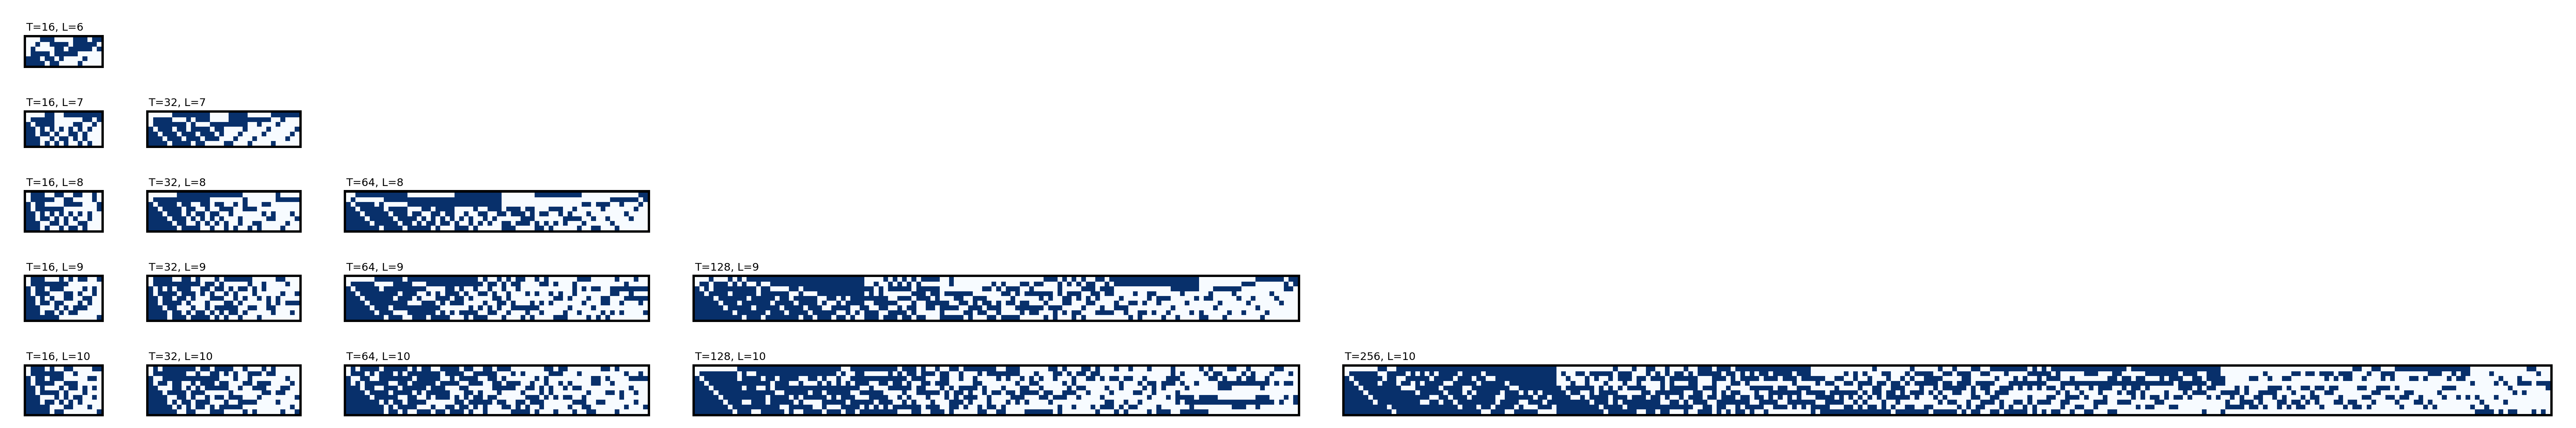

In [41]:
from mpl_toolkits.axes_grid1 import ImageGrid

min_hamming_weight = 2
sample_id_prefix = 'sa_bac__second_wave__'
source_nonuniformity = 1000.

subset_sa_bac_df = select_rows(
    sa_bac_df=sa_bac_df,
    sample_id_prefix=sample_id_prefix,
    min_hamming_weight=min_hamming_weight,
    source_nonuniformity=source_nonuniformity)

x_axis = 'n_types'
y_axis = 'code_length'
x_pad = 10
y_pad = 10
scale = 0.2
border_width = 0.05

x_value_set = set(subset_sa_bac_df[x_axis])
y_value_set = set(subset_sa_bac_df[y_axis])

x_axis_sum = sum(x_value_set) + x_pad * len(x_value_set)
y_axis_sum = sum(y_value_set) + y_pad * len(y_value_set)

fig = plt.figure(figsize=(scale * x_axis_sum, scale * y_axis_sum))
ax = plt.gca()
ax.set_xlim((0, x_axis_sum))
ax.set_ylim((0, y_axis_sum))
plt.axis('off')

x_offset = 0.5 * x_pad
for x in sorted(x_value_set):
    y_offset = 0.25 * y_pad
    
    for y in sorted(y_value_set)[::-1]:
        row = subset_sa_bac_df[(subset_sa_bac_df[x_axis] == x) & (subset_sa_bac_df[y_axis] == y)]
        
        if len(row) > 1:
            
            raise ValueError(f"Multiple values for {x} and {y}!")
            
        elif len(row) == 1:
            
            sample_id = row.iloc[0]['entity:sample_id']
            codebook_tl = sa_bac_best_codebook_tl_dict[sample_id]
            
            # sort codebook
            codebook_tl = codebook_tl[:, np.lexsort(codebook_tl[::-1, :])[::-1]]
            
            # border
            ax.imshow(
                np.zeros_like(codebook_tl),
                extent=[x_offset - border_width * x_pad,
                        x_offset + x + border_width * x_pad,
                        y_offset - border_width * y_pad,
                        y_offset + y + border_width * y_pad],
                aspect='equal', cmap=plt.cm.Greys_r)
            
            # codebook
            ax.imshow(codebook_tl.T, extent=[x_offset, x_offset + x, y_offset, y_offset + y], aspect='equal', cmap=plt.cm.Blues_r)
            
            # text
            ax.text(x_offset, y_offset + y + 0.15 * y_pad, f'T={x}, L={y}', fontsize=32)
            
        y_offset += (y + y_pad)
        
    x_offset += (x + x_pad)

fig.tight_layout()
plt.savefig(f'./output/{sample_id_prefix}sa_codebooks__min_hw_{min_hamming_weight}__src_nonunif_{int(source_nonuniformity)}.png',
            dpi=16, facecolor='white', edgecolor='none')

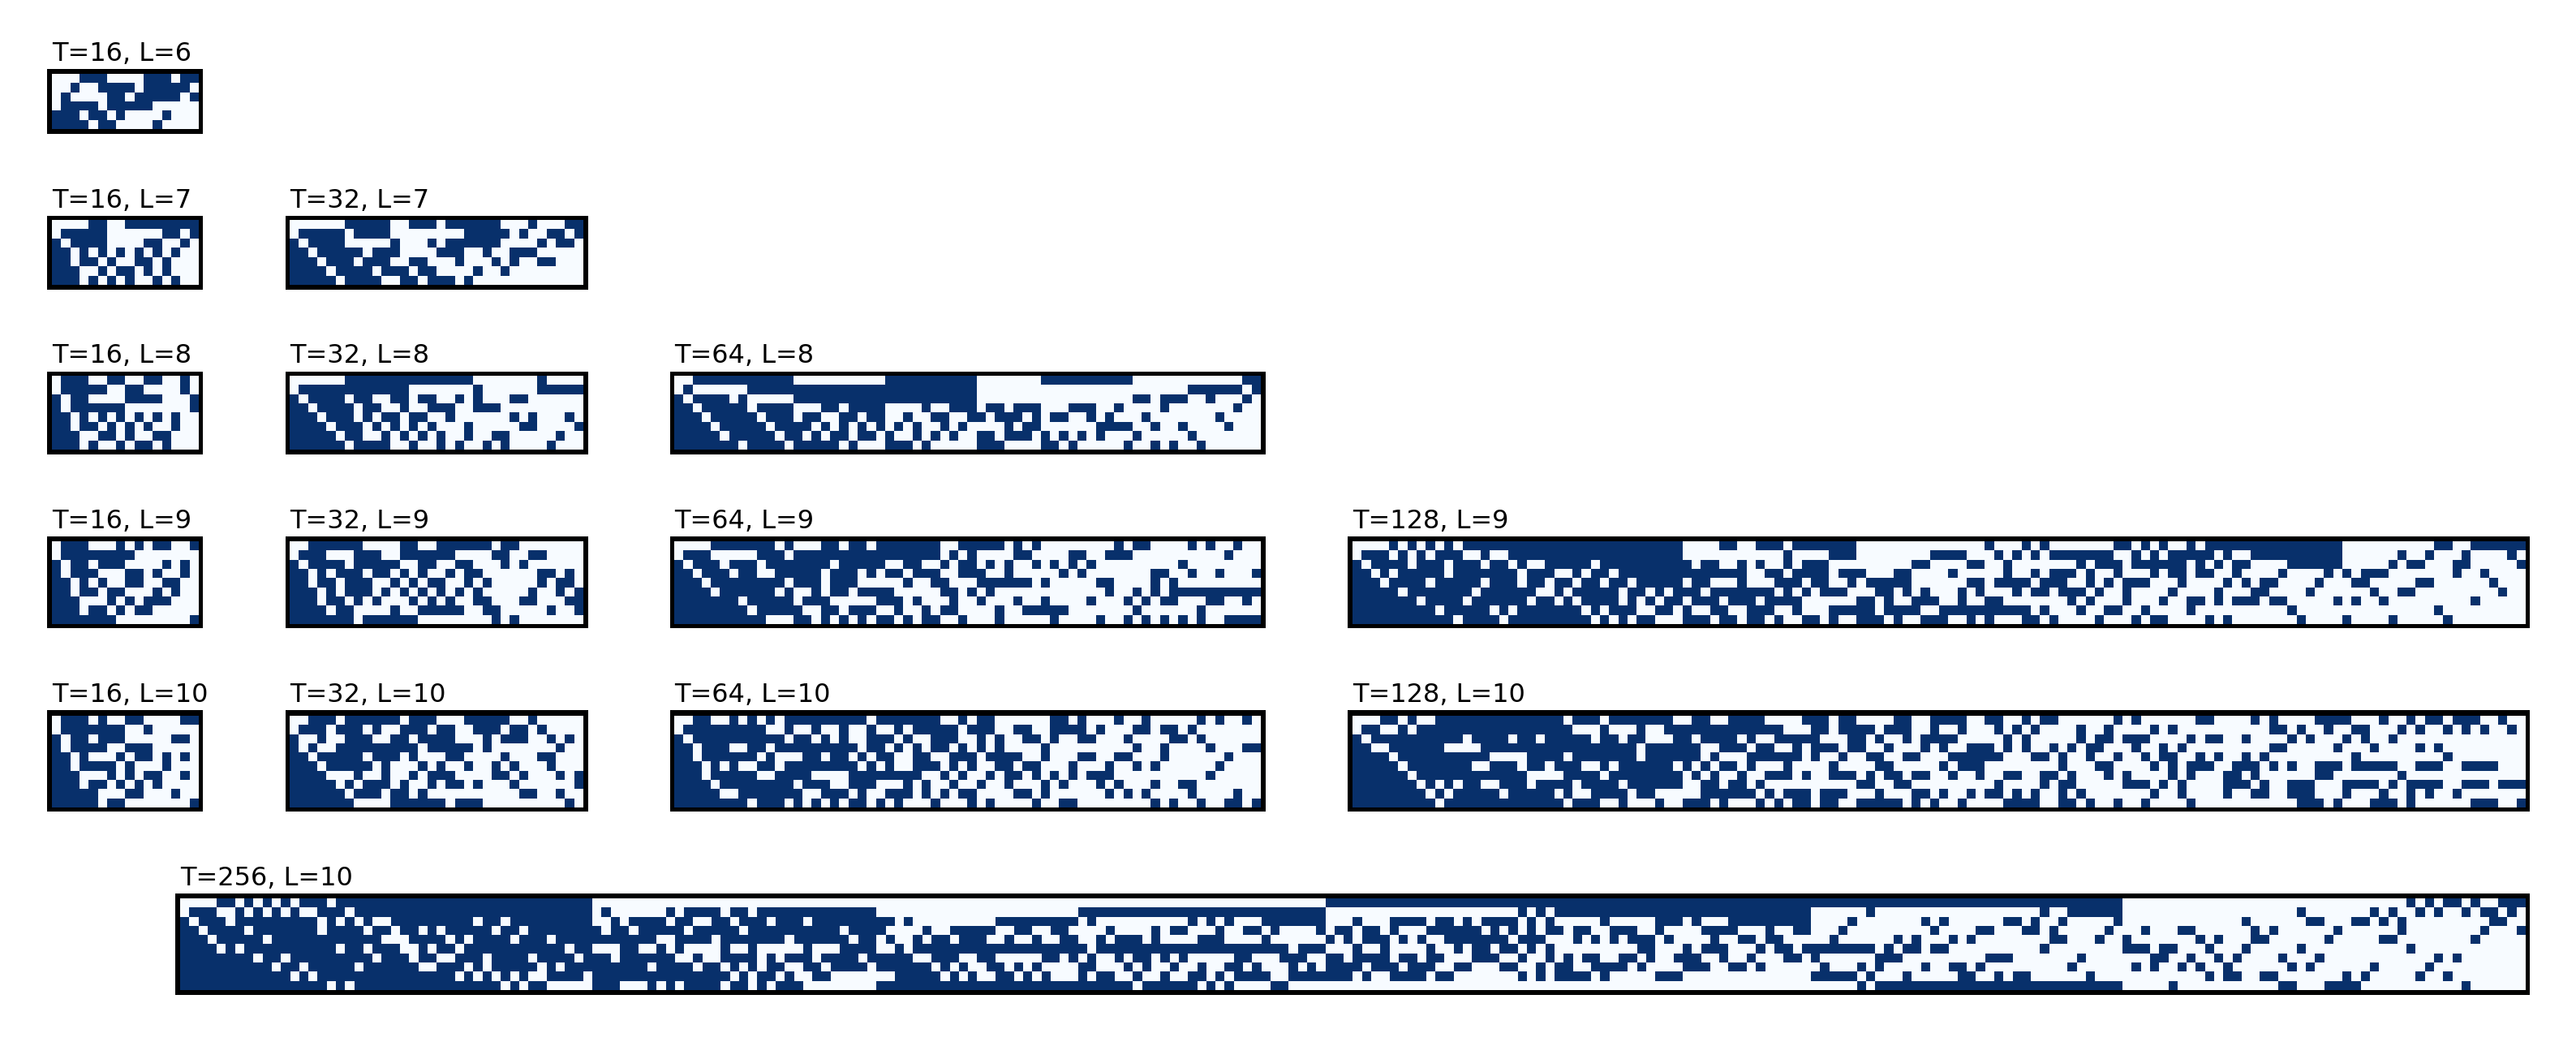

In [92]:
from mpl_toolkits.axes_grid1 import ImageGrid

min_hamming_weight = 2
sample_id_prefix = 'sa_bac__first_wave__'
source_nonuniformity = 1000.

subset_sa_bac_df = select_rows(
    sa_bac_df=sa_bac_df,
    sample_id_prefix=sample_id_prefix,
    min_hamming_weight=min_hamming_weight,
    source_nonuniformity=source_nonuniformity)

x_axis = 'n_types'
y_axis = 'code_length'
x_pad = 10
y_pad = 10
scale = 0.2
border_width = 0.05

x_value_set = set(subset_sa_bac_df[x_axis])
x_value_set.remove(256)
y_value_set = set(subset_sa_bac_df[y_axis])

x_axis_sum = sum(x_value_set) + x_pad * len(x_value_set)
y_axis_sum = sum(y_value_set) + y_pad * len(y_value_set) 

fig = plt.figure(figsize=(scale * x_axis_sum, scale * y_axis_sum))
ax = plt.gca()
ax.set_xlim((0, x_axis_sum))
ax.set_ylim((-10 - 1.25 * y_pad, y_axis_sum))
plt.axis('off')

x_offset = 0.5 * x_pad
for x in sorted(x_value_set):
    y_offset = 0.25 * y_pad
        
    for y in sorted(y_value_set)[::-1]:
        
        row = subset_sa_bac_df[(subset_sa_bac_df[x_axis] == x) & (subset_sa_bac_df[y_axis] == y)]
        
        if len(row) > 1:
            
            raise ValueError(f"Multiple values for {x} and {y}!")
            
        elif len(row) == 1:
            
            sample_id = row.iloc[0]['entity:sample_id']
            codebook_tl = sa_bac_best_codebook_tl_dict[sample_id]
            
            # sort codebook
            codebook_tl = codebook_tl[:, np.lexsort(codebook_tl[::-1, :])[::-1]]
            
            # border
            ax.imshow(
                np.zeros_like(codebook_tl),
                extent=[x_offset - border_width * x_pad,
                        x_offset + x + border_width * x_pad,
                        y_offset - border_width * y_pad,
                        y_offset + y + border_width * y_pad],
                aspect='equal', cmap=plt.cm.Greys_r)
            
            # codebook
            ax.imshow(codebook_tl.T, extent=[x_offset, x_offset + x, y_offset, y_offset + y], aspect='equal', cmap=plt.cm.Blues_r)
            
            # text
            ax.text(x_offset, y_offset + y + 0.15 * y_pad, f'T={x}, L={y}', fontsize=32)
            
        y_offset += (y + y_pad)
        
    x_offset += (x + x_pad)


x = 256
y = 10
x_offset = 0.5 * x_pad + 14
y_offset = - 10 - 0.75 * y_pad

row = subset_sa_bac_df[(subset_sa_bac_df[x_axis] == x) & (subset_sa_bac_df[y_axis] == y)]

if len(row) > 1:

    raise ValueError(f"Multiple values for {x} and {y}!")

elif len(row) == 1:

    sample_id = row.iloc[0]['entity:sample_id']
    codebook_tl = sa_bac_best_codebook_tl_dict[sample_id]

    # sort codebook
    codebook_tl = codebook_tl[:, np.lexsort(codebook_tl[::-1, :])[::-1]]

    # border
    ax.imshow(
        np.zeros_like(codebook_tl),
        extent=[x_offset - border_width * x_pad,
                x_offset + x + border_width * x_pad,
                y_offset - border_width * y_pad,
                y_offset + y + border_width * y_pad],
        aspect='equal', cmap=plt.cm.Greys_r)

    # codebook
    ax.imshow(codebook_tl.T, extent=[x_offset, x_offset + x, y_offset, y_offset + y], aspect='equal', cmap=plt.cm.Blues_r)

    # text
    ax.text(x_offset, y_offset + y + 0.15 * y_pad, f'T={x}, L={y}', fontsize=32)
    
fig.tight_layout()
plt.savefig(f'./output/{sample_id_prefix}sa_codebooks__min_hw_{min_hamming_weight}__src_nonunif_{int(source_nonuniformity)}.png',
            dpi=32, facecolor='white', edgecolor='none')